# Hyperspectral Remote Sensing Scenes Anlysis

In this homework you are asked to analyse the images collected from saltelites with hyperspectral cameras from a particular earth region.

## 1. Data preparation (20P)

* Download the _Indian Pines_ dataset from the 
__[Hyperspectral Data](http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes)__  website in order to perform the classification. - DONE

* Split data into __train__ and __test__ set in proportions 80% to 20% - DONE

In [1]:
import numpy as np
import scipy.io
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import spectral

### Explore Indian Pines data
This scene was gathered by AVIRIS sensor over the Indian Pines test site in North-western Indiana and consists of 145*145 pixels and 224 spectral reflectance bands in the wavelength range 0.4–2.5 10^(-6) meters.

Data shape: (145, 145, 200)
Labels shape: (145, 145)
Max. pixel value: (145, 145)


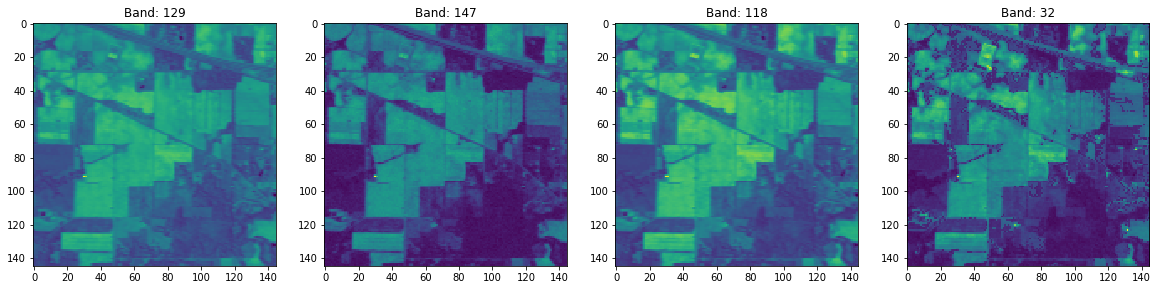

Text(0.5,1,'Ground Truth of pine data_set')

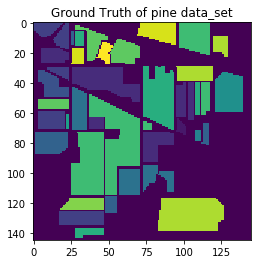

In [2]:
# load the data
data = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# shapes
print(f"Data shape: {data.shape}")
print(f"Labels shape: {ground_truth.shape}")
print(f"Max. pixel value: {data.max(2).shape}")

# plot some sample bands
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,10))
i = np.random.randint(data.shape[2])
ax1.imshow(data[:,:,i])
ax1.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax2.imshow(data[:,:,i])
ax2.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax3.imshow(data[:,:,i])
ax3.set_title(f"Band: {i}")

i = np.random.randint(data.shape[2])
ax4.imshow(data[:,:,i])
ax4.set_title(f"Band: {i}")

plt.show()

plt.imshow(ground_truth)
plt.title("Ground Truth of pine data_set")

### Split the data

In [3]:
# prepare data for split
data = data.reshape(-1,200)
ground_truth = ground_truth.reshape(-1)

# removing class 0 data and labels
data_no_zero = data[np.argwhere(ground_truth!=0)].reshape(-1,200)
ground_truth_no_zero = ground_truth[np.argwhere(ground_truth!=0)]

training_data = data_no_zero[:int(.8*data_no_zero.shape[0])]
training_labels = ground_truth_no_zero[:int(.8*ground_truth_no_zero.shape[0])]

test_data = data_no_zero[int(.8*data_no_zero.shape[0]):]
test_labels = ground_truth_no_zero[int(.8*ground_truth_no_zero.shape[0]):]

print(f"Length of training set: {training_data.shape[0]}")
print(f"Length of test set: {test_data.shape[0]}")

Length of training set: 8199
Length of test set: 2050


## 2. Data Classification
In this section we'll apply different algorithms from the **_sklearn_** package in order to do find the best classification error.

### 2.1 Semi-supervised classification (40 P)

### Question: Use whole data set ?

* Draw 10% datapoints from each class to be used as semi-supervised labels and fix them. - DONE

* Perform the _Mixture of Gaussians_ (sklearn.mixture.GaussianMixture) clustering with full covariance matrices on the input space with the true number of classes. - DONE

* Perform the _Spectral Clustering_ (sklearn.cluster.SpectralClustering) on the feature space with the RBF kernel for building the affinity matrix with the true number of classes. - DONE

* Assign labels for each data point within a class using semi-supervised labels i.e. as maximum occurence within the class and compute the accuracy (sklearn.metrics.accuracy_score).  - DONE


* QUERSIOTN: COMPUTE ACCURACY OF LABEL ASSIGNEMNT ?



* QUESTION: TRAIN MODEL ON SELF-LABELED DATASET?


* Use the accuracy metric in order to make a _scorer_ (sklearn.metrics.make_scorer) and perform cross-validation parameter tuning with the grid search engine (_GridSearchCV_ class) for both models. - CODE DONE / RUN IT

### Sample 10% of each label class and fix them

In [4]:
# get distinct labels
distinct_labels = np.unique(ground_truth_no_zero)

# creates dictionary with indices of labeled class samples(10% of total class samples) from each class
# key: class label, value: list of indices of corresponding class samples(10%)
labeled_data_dict = dict()

# creates dictionary with indices of unlabeled class samples(90% of total class samples) from each class
# key: class label, value: list of indices of corresponding class samples(90%)
unlabeled_data_dict = dict()

# Get 10% of each class. Efficient loop, since we only iterate over indices
for label in distinct_labels:
    shuffled_indices = np.random.permutation(np.where(ground_truth_no_zero==label)[0])
    labeled_data_dict[label] = shuffled_indices[:int(.1*len(shuffled_indices))]
    unlabeled_data_dict[label] = shuffled_indices[int(.1*len(shuffled_indices)):]

# build inv labeled_data_indices dict
# key: data-sample index, value: assigned label
inv_labeled_data_dict = dict()
for k,v in labeled_data_dict.items():
    for v2 in v:
        inv_labeled_data_dict[v2] = k

# labeled training data indices
labeled_data_indices = np.concatenate(list(labeled_data_dict.values()))
# unlabeled training data indices
unlabeled_data_indices = np.concatenate(list(unlabeled_data_dict.values()))
        
# fixed labeled dataset
labeled_data = data_no_zero[labeled_data_indices]
labeled_data_labels = ground_truth_no_zero[labeled_data_indices]
 
# fixed unlabeled data
unlabeled_data = data_no_zero[unlabeled_data_indices]
unlabeled_data_labels = ground_truth_no_zero[unlabeled_data_indices]

In [5]:
print(f"Length of training data: {training_data.shape[0]}")
print(f"Length of labeled data set: {labeled_data.shape[0]}")
print(f"Length of unlabeled data set: {unlabeled_data.shape[0]}")
print(f"Fraction of training data: {round(labeled_data.shape[0]*100 / data_no_zero.shape[0])} %")

Length of training data: 8199
Length of labeled data set: 1018
Length of unlabeled data set: 9231
Fraction of training data: 10 %


### Gaussian Mixture Classifier

In [ ]:
class GMMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, cov_type='full', max_iter=100, n_init=1):
        self.cov_type = cov_type
        self.max_iter = max_iter
        self.n_init = n_init

        self.gmm = GaussianMixture(
            n_components=len(distinct_labels),
            covariance_type=self.cov_type,
            max_iter=self.max_iter,
            n_init=self.n_init
        )

    def fit(self, X):
        self.gmm.fit(X)

        return self

    def predict(self, X=unlabeled_data, y=inv_labeled_data_dict):
        """Assign label to each cluster, according to max occ. of labeled points within those clusters
        Parameters:
            - data
            - labeled data
        Returns:
            - (re-)labeled gauss cluster predictions of unlabeled samples
        """
        clustered_data_labels = self.gmm.predict(X)

        # assign labels to each cluster based on max occurence of label of
        # labeled data samples within that cluster
        for cluster_id in np.unique(clustered_data_labels):
            cluster_indices = np.argwhere(clustered_data_labels == cluster_id)
            tmp_labels = []

            for index in cluster_indices:
                # get real data label if exists - only take labels from semi supervised data
                try:
                    tmp_label = y[index[0]]
                    tmp_labels.append(tmp_label)
                except:
                    continue

            if tmp_labels != []:
                # get most frequent label
                tmp_counts = np.bincount(tmp_labels)
                max_label = np.argmax(tmp_counts)

                # assign all cluster points to the max label
                clustered_data_labels[cluster_indices] = max_label
        y = clustered_data_labels

        return y

    def score(self, X, y_true=unlabeled_data_labels):
        # predictions for unlabeled data samples
        predictions = self.predict()
        
        return accuracy_score(predictions, y_true)

In [ ]:
classifier_gmm = GMMClassifier()
classifier_gmm = classifier_gmm.fit(data)
cluster_predictions = classifier_gmm.predict(unlabeled_data)

In [ ]:
# Compute accuracy score
gauss_acc = accuracy_score(cluster_predictions, unlabeled_data_labels)
print(f"Accuracy using Gaussian Mixture Clustering: {100*gauss_acc}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
params = {
    'cov_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': [100,10,1],
    'n_init': [100,10,1]
}

grid = GridSearchCV(
            estimator=GMMClassifier(),
            param_grid=params,
            cv=3
)

grid = grid.fit(labeled_data)

# Print best results
print(f"Best achieved val accuracy: {grid.best_score_}")
print(f"Best hyperparams: {grid.best_params_}")

### Spectral clustering Classification


In [ ]:
class SpectralClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, affinity='rbf', gamma=1.0, assign_labels="kmeans", full_labels=ground_truth):    
        self.full_labels=full_labels
        self.affinity=affinity 
        self.gamma=gamma
        self.assign_labels=assign_labels
        self.spec_clusterer = SpectralClustering(
            n_clusters=len(distinct_labels),
            affinity=self.affinity,
            gamma=self.gamma,
            assign_labels=self.assign_labels
        )
        
    def fit(self, X, y):
        self.train_labels = y
        self.spec_clustering=self.spec_clusterer.fit(X)
        
        return self
        
    def predict(self, y=inv_labeled_data_dict):
        
        """Assign label to each cluster, according to max occ. of labeled points within those clusters
        Parameters:
            - data
            - labeled data
        Returns:
            - (re-)labeled gauss cluster predictions of unlabeled samples
        """
        
        clustered_data_labels = self.spec_clustering.labels_
        
        # assign labels to each cluster based on max occurence of label of 
        # labeled data samples within that cluster
        for cluster_id in np.unique(clustered_data_labels):
            cluster_indices = np.argwhere(clustered_data_labels == cluster_id)
            tmp_labels = []
    
            for index in cluster_indices:
                # get real data label if exists - only take labels from semi supervised data
                try:
                    tmp_label = y[index[0]]
                    tmp_labels.append(tmp_label)
                except:
                    continue
    
            if tmp_labels != []:
                # get most frequent label
                tmp_counts = np.bincount(tmp_labels)
                max_label = np.argmax(tmp_counts)
    
                # assign all cluster points to the max label
                clustered_data_labels[cluster_indices] = max_label
            
        y = clustered_data_labels
        
        return y
    
    def score(self, X=None, y=None):
        predictions = self.predict()
        y_true=self.train_labels

        return accuracy_score(predictions, y_true)

In [ ]:
classifier_spectral = SpectralClassifier()
classifier_spectral = classifier_spectral.fit(data, ground_truth)
cluster_predictions = classifier_spectral.predict()

# Compute accuracy score
spec_acc = accuracy_score(cluster_predictions[unlabeled_data_indices], ground_truth[unlabeled_data_indices])
print(f"Accuracy using Spectral Clustering Classification: {100*spec_acc}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
params = {
    'gamma': [1000,100,10,1,0.1,0.01],
    'assign_labels': ['kmeans', 'discretize']
}

grid = GridSearchCV(
            estimator=SpectralClassifier(),
            param_grid=params,
            cv=3
)

grid = grid.fit(data, ground_truth)

# Print best results
print(f"Best achieved val accuracy: {grid.best_score}")
print(f"Best hyperparams: {grid.best_params_}")

### 2.2 Supervised classification (20 P)

* Run multiclass Support Vector Machine classification in order to find labels for the unlabeled pixels. 


* QUESTION: TRAIN MODEL ON SELF-LABELED DATASET?


* Compute the overall pixels-wise error for the data _test_ set.

* Use this metric in order to make a _scorer_ (_sklearn.metrics.make_scorer_) and perform cross-validation parameter tuning with the grid search engine (_GridSearchCV_ class).

### SVM multiclass classification

In [ ]:
svm = SVC()
svm.fit(training_data, training_labels)

In [ ]:
test_set_predictions = svm.predict(test_data)
svm_test_acc = accuracy_score(test_set_predictions, test_labels)
print(f"SVM test classification accuracy: {round(svm_test_acc*100,6)}%")

### Fine Tuning Hyper Parameters with Cross Validation

In [ ]:
# Define hyper-params to optimize
#params = [
#    {'C': [1000, 100, 10, 1, 0.1], 'kernel': ['linear']},
#    {'C': [1000, 100, 10, 1, 0.1], 'gamma': ['scale', 'auto', 1000, 100, 10, 1, 0.1], 'kernel': ['rbf']},
#    {'C': [1000, 100, 10, 1, 0.1], 'degree': [3, 2, 1], 'kernel': ['poly']},
#    {'C': [1000, 100, 10, 1, 0.1], 'kernel': ['sigmoid']},
#]

params = [
    {'C': [1], 'kernel': ['linear']},
] 

# Define scorer
def test_scorer(test_data, test_labels):
    score = accuracy_score(test_data, test_labels)
    return score
    
accuracy_scorer = make_scorer(test_scorer, greater_is_better=True)

svm_grid = GridSearchCV(
    estimator=SVC(), 
    param_grid=params, 
    scoring=accuracy_scorer
)

svm_grid = svm_grid.fit(training_data, training_labels)

print(svm_grid.best_score_)
print(svm_grid.best_params_)
test_predictions = svm_grid.predict(test_data)

test_acc = accuracy_score(test_predictions, test_labels)
print(f"Final Test accuracy after Grid Search: {test_acc}")

## 3. Data Visualization (20 P)

* Visualize your classification results as the __covermap__ (_spectral.imshow_ ) using different colors for each class and compare it visually with the __normal__ image representation. - TBD

* Does your __covermap__ respresent the analysed data properly or not ? Compute the overall pixels-wise classification error - TBD

## 4. Optional Task (+50 P)

* Define your own Deep Neural Network Architecture in order to defeat the best model you've already found from the previous tasks.

* Show that your resuls are better or similar to the results from the previous models empirically as well as visually.

In [12]:
import time
import copy
import itertools
import sys

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR

# Trial: Use Conv. Neural Network(pretrained)
### max. SVM acc. to beat ~ 62.615933%

In [13]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class NNClassifier(nn.Module):
    
    def __init__(self, inp_size):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(200, 50)
        self.fc2 = nn.Linear(50, 16)
    
    def forward(self, x):
        
        output = F.relu(self.fc1(x))
        output = self.fc2(output)
        
        return output

In [58]:
torch_training_data = CustomDataset(
    training_data[:int(training_data.shape[0]*0.8),:].astype(float), 
    training_labels[:int(training_data.shape[0]*0.8)]
)

torch_val_data = CustomDataset(
    training_data[int(training_data.shape[0]*0.8):,:].astype(float), 
    training_labels[int(training_data.shape[0]*0.8):]
)

torch_test_data = CustomDataset(
    test_data.astype(float), 
    test_labels
)

In [59]:
def train(parameters):
    # define torch data loaders
    batch_size = parameters[0]
    learning_rate = parameters[1]
    weigh_decay = parameters[2]

    train_loader = torch.utils.data.DataLoader(
        torch_training_data, 
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        torch_val_data, 
        batch_size=batch_size,
        shuffle=True
    )
    
    # Define Model
    inp_size = batch_size * 200
    epochs = 20
    best_model = None
    best_val_acc = 0.0

    model = NNClassifier(inp_size)

    # define optimizer
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=0.001,
        weight_decay=0.01
    )

    #lambda1 = lambda epoch: 0.95 ** epoch
    #scheduler = LambdaLR(optimizer, lr_lambda=lambda1)


    # define loss
    criterion = torch.nn.CrossEntropyLoss()

    for e, epoch in enumerate(range(epochs)):
    
        #scheduler.step()
    
        # evaluation loop
        with torch.no_grad():
            total = 0.0
            correct_predicted = 0.0
        
            for i, (data, labels) in enumerate(val_loader):
        
                optimizer.zero_grad()
                out = model(data)
                predictions = out.max(1)[1]
            
                correct_predicted += (predictions == labels.squeeze()).sum()
                total += labels.shape[0]
        
            val_acc = (correct_predicted.item() / total)
            print(f"EPOCH: {e}, validation accuracy: {val_acc*100}%")
        
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = copy.deepcopy(model)
        
        # training loop
        total_loss = 0.0
        for i, (data, labels) in enumerate(train_loader):
        
            model.train()
        
            optimizer.zero_grad()
            out = model(data)
        
            try:
                loss = criterion(out, labels.squeeze())
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            except:
                continue
        print(f"EPOCH: {e}, total loss: {total_loss} ")
    
    return best_model, best_val_acc

In [60]:
#learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
#batch_sizes = [100, 50, 25, 12, 6, 3]
#weight_decays = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

learning_rates = [0.01]
batch_sizes = [12]
weight_decays = [0.005]

param_list = list(itertools.product(*[batch_sizes, learning_rates, weight_decays]))

In [64]:
import time
final_acc = 0.0
final_model = None
final_params = None

for params in param_list:
    
    tmp_best_model, tmp_best_val_acc = train(params)
    
    if tmp_best_val_acc > final_acc:
        print(f"FOUND NEW TOP ACC:")
        print(f"Validation Accuracy: {tmp_best_val_acc*100}%")
        final_acc = tmp_best_val_acc
        final_model = copy.deepcopy(tmp_best_model)
        final_params = params
        
        #data = scipy.io.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
        #out = tmp_best_model(torch.Tensor(data.reshape(-1, 200).astype(float))).max(1)[1]
        #plt.imshow(out.reshape(145,145))
        #plt.title("Predicted Image of Pine Data set")
        #plt.show()
        #time.sleep(10)

test_loader = torch.utils.data.DataLoader(
        torch_test_data, 
        batch_size=10,
        shuffle=True
)        
# Evaluate final Test accuracy
with torch.no_grad():
    total = 0.0
    correct_predicted = 0.0
        
    for i, (data, labels) in enumerate(test_loader):
        
        optimizer.zero_grad()
        out = final_model(data)
        predictions = out.max(1)[1]
            
        correct_predicted += (predictions == labels).sum()
        total += len(labels)
        
    test_acc = (correct_predicted.item() / total)
    print(f"Final test accuracy: {test_acc*100}%")

EPOCH: 0, validation accuracy: 0.0%
EPOCH: 0, total loss: 22664871.27111578 
EPOCH: 1, validation accuracy: 0.0%
EPOCH: 1, total loss: 1270.26309800148 
EPOCH: 2, validation accuracy: 60.30487804878049%
EPOCH: 2, total loss: 1264.3654284477234 
EPOCH: 3, validation accuracy: 60.30487804878049%
EPOCH: 3, total loss: 1237.4776344299316 
EPOCH: 4, validation accuracy: 60.30487804878049%
EPOCH: 4, total loss: 1246.5172033309937 
EPOCH: 5, validation accuracy: 60.30487804878049%
EPOCH: 5, total loss: 1220.72372341156 
EPOCH: 6, validation accuracy: 60.30487804878049%
EPOCH: 6, total loss: 1220.072566986084 
EPOCH: 7, validation accuracy: 60.30487804878049%
EPOCH: 7, total loss: 1200.3416011333466 
EPOCH: 8, validation accuracy: 60.30487804878049%
EPOCH: 8, total loss: 1199.3509662151337 
EPOCH: 9, validation accuracy: 60.30487804878049%
EPOCH: 9, total loss: 1200.0736651420593 
EPOCH: 10, validation accuracy: 60.30487804878049%
EPOCH: 10, total loss: 1183.2617223262787 
EPOCH: 11, validatio

NameError: name 'optimizer' is not defined

# Visualize Results